In [1]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt

In [29]:
from qutip import *
import numpy as np
from scipy.constants import pi
from scipy import sqrt, log
from IPython.display import clear_output

In [8]:
omega_r = 2*pi

g=0.007*omega_r
N=3

def a():
    return destroy(N)
def build_H_undr(omega_q = 0.6*omega_r, delta = 0):
    H_q = tensor(identity(N), sigmaz()*sqrt(omega_q**2+delta**2)/2)
    H_r = tensor(omega_r*(1/2+a().dag()*a()), identity(2))
    H_int = g*tensor(a() + a().dag(), delta/sqrt(omega_q**2+delta**2)*sigmaz()-
                     omega_q/sqrt(omega_q**2+delta**2)*sigmax())
    return H_q+H_r +H_int


def build_H_dr(t_on=0, t_off=1000):
    return [A*tensor(destroy(N)+create(N), identity(2)), "np.sin(omega_f*t)/(1+np.exp(-t+%d))/(1+np.exp(t-%d))"%(t_on, t_off)]

def build_c_ops():
    return [tensor(identity(N), sqrt(gamma_rel)*sigmam()), tensor(identity(N), sqrt(gamma_deph)*sigmaz()), 
            tensor(sqrt(kappa)*destroy(N), identity(2))]

In [9]:
def evals(omega_q = 0.6*omega_r, delta = 0):
    return build_H_undr(omega_q, delta).eigenenergies()
def evecs(omega_q = 0.6*omega_r, delta = 0):
    return build_H_undr(omega_q, delta).eigenstates()[1]

In [11]:
evals(omega_q=.2*omega_r, delta=-0.97975*omega_r)

array([ -1.60441861e-04,   6.27408655e+00,   6.29168067e+00,
         1.25540678e+01,   1.25789751e+01,   1.88500180e+01])

In [37]:
## Dynamics parameters
opts = Options(rhs_reuse=True)

kappa = 5e-4
gamma_rel = .0
gamma_deph =.0
g=0.007*omega_r
A = 1e-3
T_end = 5000
Ts = np.linspace(0, T_end, 800)
args = {}

## Эволюция 

In [38]:
args['omega_f']=omega_r

c_ops=build_c_ops()#_new(.2*omega_r, delta=0.97975*omega_r)
result1 = mesolve([build_H_undr(omega_q = .2*omega_r, delta=0.97975*omega_r), build_H_dr(-100, 1e4)], 
                 evecs(omega_q = .2*omega_r, delta=0.97975*omega_r)[0],  Ts,
                        c_ops, [], args=args, progress_bar=True)

с_ops = build_c_ops()#_new(.2*omega_r, delta=-0.97975*omega_r)
result2 = mesolve([build_H_undr(omega_q = .2*omega_r, delta=-0.97975*omega_r), build_H_dr(-100, 1e4)], 
                 evecs(omega_q = .2*omega_r, delta=-0.97975*omega_r)[0],  Ts, c_ops,
                         [], args=args, progress_bar=True)
clear_output()

In [47]:
# expects = [abs(expect(tensor(a(),identity(2)), state)) for state in result.states]
H1 = build_H_undr(omega_q = .2*omega_r, delta=0.97975*omega_r)
H2 = build_H_undr(omega_q = .2*omega_r, delta=-0.97975*omega_r)
expects1 = [abs(expect(tensor(a(), identity(2)), state)) for state in result1.states]
expects2 = [abs(expect(tensor(a(), identity(2)), state)) for state in result2.states]

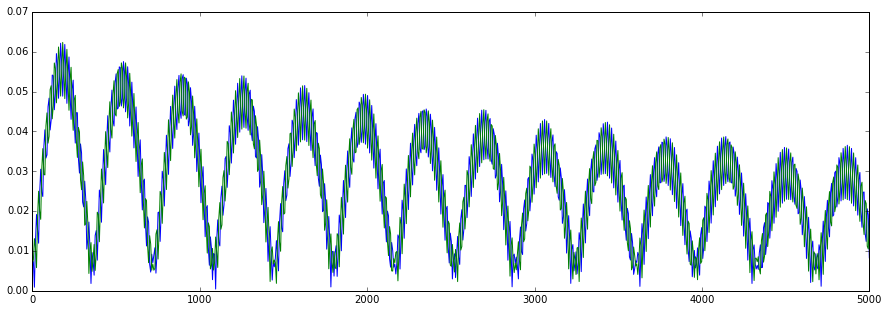

In [49]:
plt.plot(Ts, np.array(expects1), '-')
plt.plot(Ts, np.array(expects2), '-')
# plt.plot(Ts, np.array(expects2)- np.array(expects1), '-')

plt.gcf().set_size_inches(15,5)

## Ожидаемое стабильное состояние 

In [44]:
args['omega_f']=omega_r
H = liouvillian(build_H_undr(omega_q=0.2*omega_r, delta=0.97975*omega_r), c_ops)
U = propagator([H, build_H_dr(-100, 1e4)], 
               2*pi/args['omega_f'], [], args=args)

In [45]:
rho = propagator_steadystate(U)

In [46]:
abs(expect(tensor(a(), identity(2)), rho))

0.007052719311815941

## Новый диссипатор

In [24]:
def build_c_ops_new(omega_q = .6*omega_r, delta=0):
    def abs_sq(qobj):
        return qobj.dag()*qobj
    c_ops = []
    c_op_kappa_base = tensor(a().dag()+a(), identity(2))
    c_op_gamma_rel_base = tensor(identity(N), sigmax())
    c_op_gamma_deph_base = tensor(identity(N), sigmaz())
    c_op_gamma_deph_jj = 0
    
    evecs_ = evecs(omega_q, delta)
    for i in range(0, 2*N):
        for j in range(0, 2*N):
            if j>i:
                Gamma_ij_kappa = sqrt(kappa)*c_op_kappa_base.matrix_element(evecs_[i].dag(), evecs_[j])
                Gamma_ij_gamma_rel = sqrt(gamma_rel)*c_op_gamma_rel_base.matrix_element(evecs_[i].dag(), evecs_[j])
                
                if Gamma_ij_kappa != 0:
                    c_ops.append(Gamma_ij_kappa*evecs_[i]*evecs_[j].dag())
                if Gamma_ij_gamma_rel != 0:
                    c_ops.append(Gamma_ij_gamma_rel*evecs_[i]*evecs_[j].dag())
            if j != i:
                Gamma_ij_gamma_deph=sqrt(gamma_deph)*c_op_gamma_deph_base.matrix_element(evecs_[i].dag(), evecs_[j])
                if Gamma_ij_gamma_deph!=0:
                    c_ops.append(Gamma_ij_gamma_deph*evecs_[i]*evecs_[j].dag())
            if j == i:
                Gamma_ij_gamma_deph = sqrt(gamma_deph) * c_op_gamma_deph_base.matrix_element(evecs_[i].dag(), evecs_[i])
#                 if Gamma_ij_gamma_deph != 0:
#                     c_op_gamma_deph_jj+= Gamma_ij_gamma_deph*evecs_[i]*evecs_[i].dag()
    if c_op_gamma_deph_jj!=0:
        c_ops.append(c_op_gamma_deph_jj)
    return c_ops

In [305]:
rm -f *pyx